# Ноутбук с первичным базовым решением
## Здесь мы сильно не думаем о работе с фичами, алгоритмах, гиперпараметрах и всем таком. Просто убеждаемся, что все работает корректно, и мы все понимаем :)

In [1]:
import os
os.chdir('../')

In [2]:
!pwd

/c/Users/user/SpaceshipTitanic-Template


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [4]:
# Читаем данные
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Пример решения, которое надо положить на kaggle
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [5]:
# Посмотрим, что тут вообще происходит 🤓
train.shape
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


---

# NB:

In [6]:
# В соревновании, кто-то использовал Name для формирования дополнительных признаков, но конкретно мы сейчас этого делать не будем. Мы строим самую БАЗОВУЮ модель!
train.drop(columns='Name', inplace=True)
test.drop(columns='Name', inplace=True)

In [7]:
# Фича PassengerId (в общем-то как и Name) не должна играть большой роли, но мы обязательно проверим эту гипотезу в будущем!

def extract_id(s, personal=True):
    group_id, indiv_id = map(str, s.split('_'))
    if personal:
        return indiv_id
    else:
        return group_id

# Пример
extract_id('0001_01', personal=True)

'01'

In [8]:
train.drop(columns='PassengerId', inplace=True)
test.drop(columns='PassengerId', inplace=True)

## Description
В этом соревновании задача — предсказать, был ли пассажир перенесен в альтернативное измерение во время столкновения космического корабля «Титаник» с пространственно-временной аномалией.

---

**PassengerId** - Уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg указывает на группу, с которой путешествует пассажир, а pp — его номер в группе. Люди в группе часто являются членами семьи, но не всегда.

**Name** - Имя и фамилия пассажира.

**Transported** - Целевая переменная. Показывает был ли пассажир перенесен в другое измерение.

---

**HomePlanet** — Планета, с которой отправился пассажир, обычно планета его постоянного проживания.

**CryoSleep** - Признак, показывающий выбрал ли пассажир анабиоз (=криосон) на время рейса. Пассажиры в криосне ограничены своими каютами.

**Cabin** — Номер каюты, в которой находился пассажир. Записан в формате deck/num/side, где side может быть либо P для левого борта, либо S для правого борта.

**Destination** - Планета, на которую высадится пассажир.

**Age** - Возраст пассажира.

**VIP** - Признак, показывающий оплатил ли пассажир VIP-обслуживание во время рейса.

**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Суммы, которые пассажир заплатил за каждое из многочисленных удобств класса люкс на космическом корабле «Титаник».

---

# EDA & Feature Transfomation

In [9]:
display(train['HomePlanet'].unique())
display(train['HomePlanet'].value_counts())
display(train['HomePlanet'].isna().sum())

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

np.int64(201)

In [10]:
# Напишем код для обработки категориальных фичей

def custom_combiner(feature, category):
    return f'OneHot__{feature}_{category}'

onehot = OneHotEncoder(
    categories='auto',
    drop='first',
    dtype=int,
    handle_unknown='ignore',
    feature_name_combiner=custom_combiner
)


def cat_transform(onehot, train, test, feature):
    # Трансформируем фичу для тренировочных данных
    transformed = onehot.fit_transform(train[[feature]]).toarray()
    transformed = pd.DataFrame(transformed, columns=onehot.get_feature_names_out())
    
    # Трансформируем фичу для тестовых данных
    transformed_test = onehot.transform(test[[feature]]).toarray()
    transformed_test = pd.DataFrame(transformed_test, columns=onehot.get_feature_names_out())
    
    # Присоединяем трансформированные фичи и удаляем исходники
    train = pd.concat([train, transformed], axis=1)
    train.drop(columns=[feature], inplace=True)
    
    test = pd.concat([test, transformed_test], axis=1)
    test.drop(columns=[feature], inplace=True)

    return train, test


In [11]:
train, test = cat_transform(onehot, train, test, 'HomePlanet')

---

In [12]:
display(train['CryoSleep'].unique())
display(train['CryoSleep'].value_counts())
display(train['CryoSleep'].isna().sum())

array([False, True, nan], dtype=object)

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

np.int64(217)

In [13]:
train, test = cat_transform(onehot, train, test, 'CryoSleep')

---

## Развернем Cabin в 3 фичи:

In [14]:
def extract_cabin(s, feature='deck'):
    if isinstance(s, str):
        deck, num, side = s.split('/') 
        if feature == 'deck':
            return deck
        if feature == 'num':
            return int(num)
        if feature == 'side':
            return side
            
    return 'None'


In [15]:
train['Cabin_deck'] = train['Cabin'].apply(extract_cabin, args=('deck', ))
train['Cabin_num'] = train['Cabin'].apply(extract_cabin, args=('num', ))
train['Cabin_side'] = train['Cabin'].apply(extract_cabin, args=('side', ))

test['Cabin_deck'] = test['Cabin'].apply(extract_cabin, args=('deck', ))
test['Cabin_num'] = test['Cabin'].apply(extract_cabin, args=('num', ))
test['Cabin_side'] = test['Cabin'].apply(extract_cabin, args=('side', ))

display(train['Cabin_deck'].unique())
display(train['Cabin_num'].unique())
display(train['Cabin_side'].unique())

# Numerical фича, из предположения что каюты пронумерованы не хаотично
# Жетский костыль, но повторюсь, что на текущий момент сильно мы не заморчиваемся
train['Cabin_num'] = train['Cabin_num'].apply(lambda x: 1894//2 if x == 'None' else x)
test['Cabin_num'] = test['Cabin_num'].apply(lambda x: 1894//2 if x == 'None' else x)

train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

array(['B', 'F', 'A', 'G', 'None', 'E', 'D', 'C', 'T'], dtype=object)

array([0, 1, 2, ..., 1892, 1893, 1894], dtype=object)

array(['P', 'S', 'None'], dtype=object)

In [16]:
display(train['Cabin_deck'].value_counts())
display(train['Cabin_side'].value_counts())

Cabin_deck
F       2794
G       2559
E        876
B        779
C        747
D        478
A        256
None     199
T          5
Name: count, dtype: int64

Cabin_side
S       4288
P       4206
None     199
Name: count, dtype: int64

In [17]:
train, test = cat_transform(onehot, train, test, 'Cabin_deck')
train, test = cat_transform(onehot, train, test, 'Cabin_side')

In [18]:
# Напишем код для обработки Numerical фичей

scaler = StandardScaler()

def num_transform(scaler, train, test, feature):
    # Трансформируем фичу для тренировочных данных
    transformed = scaler.fit_transform(train[[feature]])
    transformed = pd.DataFrame(transformed, columns=[f'Scaler__{feature}'])
    transformed = transformed.fillna(transformed.mean())

    # Трансформируем фичу для тестовых данных
    transformed_test = scaler.transform(test[[feature]])
    transformed_test = pd.DataFrame(transformed_test, columns=[f'Scaler__{feature}'])
    transformed_test = transformed_test.fillna(transformed_test.mean())

    # Присоединяем трансформированные фичи и удаляем исходники`
    train = pd.concat([train, transformed], axis=1)
    train.drop(columns=[feature], inplace=True)
    
    test = pd.concat([test, transformed_test], axis=1)
    test.drop(columns=[feature], inplace=True)

    return train, test

count    8693.000000
mean      608.302772
std       508.623033
min         0.000000
25%       173.000000
50%       448.000000
75%       983.000000
max      1894.000000
Name: Cabin_num, dtype: float64

<Axes: >

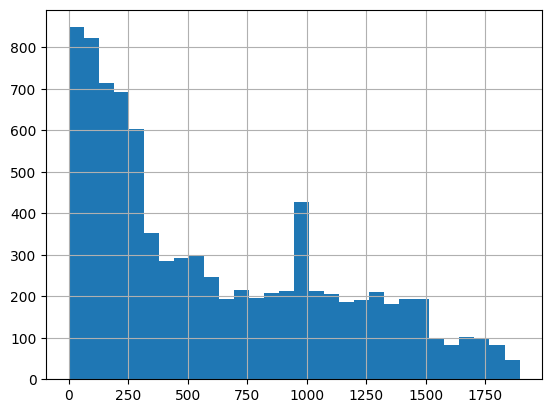

In [19]:
display(train['Cabin_num'].describe())
display(train['Cabin_num'].hist(bins=30))

In [20]:
train, test = num_transform(scaler, train, test, feature='Cabin_num')

---

In [21]:
display(train['Destination'].unique())
display(train['Destination'].value_counts())
display(train['Destination'].isna().sum())

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

np.int64(182)

In [22]:
train, test = cat_transform(onehot, train, test, 'Destination')

---

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

<Axes: >

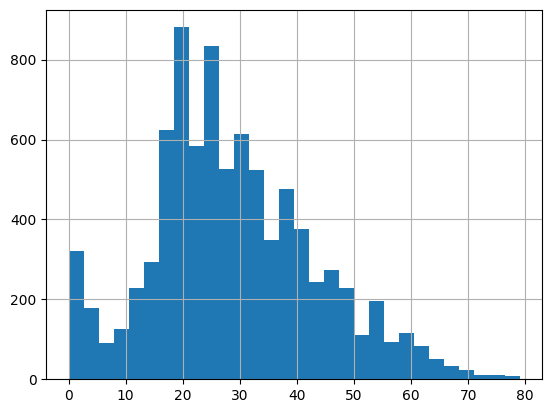

In [23]:
display(train['Age'].describe())
display(train['Age'].hist(bins=30))

In [24]:
train, test = num_transform(scaler, train, test, feature='Age')

---

In [25]:
display(train['VIP'].unique())
display(train['VIP'].value_counts())
display(train['VIP'].isna().sum())

array([False, True, nan], dtype=object)

VIP
False    8291
True      199
Name: count, dtype: int64

np.int64(203)

In [26]:
train, test = cat_transform(onehot, train, test, 'VIP')

---

In [27]:
for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    display(train[feature].describe())
    print()
    train, test = num_transform(scaler, train, test, feature=feature)

count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64

count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64

---

In [28]:
print(train.isna().any())
print(test.isna().any())

Transported                          False
OneHot__HomePlanet_Europa            False
OneHot__HomePlanet_Mars              False
OneHot__HomePlanet_nan               False
OneHot__CryoSleep_True               False
OneHot__CryoSleep_nan                False
OneHot__Cabin_deck_B                 False
OneHot__Cabin_deck_C                 False
OneHot__Cabin_deck_D                 False
OneHot__Cabin_deck_E                 False
OneHot__Cabin_deck_F                 False
OneHot__Cabin_deck_G                 False
OneHot__Cabin_deck_None              False
OneHot__Cabin_deck_T                 False
OneHot__Cabin_side_P                 False
OneHot__Cabin_side_S                 False
Scaler__Cabin_num                    False
OneHot__Destination_PSO J318.5-22    False
OneHot__Destination_TRAPPIST-1e      False
OneHot__Destination_nan              False
Scaler__Age                          False
OneHot__VIP_True                     False
OneHot__VIP_nan                      False
Scaler__Roo

# Построим модель

In [29]:
train['Transported'] = train['Transported'].astype(int)
train['Transported'].value_counts()

Transported
1    4378
0    4315
Name: count, dtype: int64

## Т.к. классы полностью сбалансированны, то про подбор порога можно забыть, по умолчанию для кросс валидации он 0.5

In [30]:
logreg = LogisticRegression()

X = train.loc[:, ~train.columns.isin(['Transported'])]
y = train['Transported']

cv_logreg = cross_validate(logreg, X, y, cv=5, scoring='accuracy')

# 95% доверительный интервал
print(f"Accuracy: {cv_logreg['test_score'].mean():.4f} (+/- {2*cv_logreg['test_score'].std():.4f})")

Accuracy: 0.7858 (+/- 0.0139)


## Чисто формальность: переберем гиперпараметр, чтобы улучшить результат

In [31]:
for c in [0.01, 0.04,
          0.1, 0.4,
          1, 4,
          10, 40]:

    logreg = LogisticRegression(C=c)
    cv_logreg = cross_validate(logreg, X, y, cv=5, scoring='accuracy')
    
    print(f"Hyperparam : {c}\nAccuracy: {cv_logreg['test_score'].mean():.4f} (+/- {2*cv_logreg['test_score'].std():.4f})\n")


Hyperparam : 0.01
Accuracy: 0.7837 (+/- 0.0160)

Hyperparam : 0.04
Accuracy: 0.7855 (+/- 0.0171)

Hyperparam : 0.1
Accuracy: 0.7840 (+/- 0.0165)

Hyperparam : 0.4
Accuracy: 0.7849 (+/- 0.0151)

Hyperparam : 1
Accuracy: 0.7858 (+/- 0.0139)

Hyperparam : 4
Accuracy: 0.7861 (+/- 0.0130)

Hyperparam : 10
Accuracy: 0.7856 (+/- 0.0129)

Hyperparam : 40
Accuracy: 0.7856 (+/- 0.0133)



## Предскажем и сохраним результат
### Конечно же сделаем kaggle-trick и обучимся на ВСЕМ наборе данных)

In [32]:
logreg = LogisticRegression(C=4)
final_train = train.loc[:, ~train.columns.isin(['Transported'])]
final_label = train['Transported']

logreg.fit(final_train, final_label)

prediction = logreg.predict_proba(test)[:, 1:]
prediction = prediction > 0.5

In [33]:
pd.DataFrame({
    'feature': final_train.columns.tolist(),
    'weight': logreg.coef_[0].tolist()
}).sort_values(by='weight')

,feature,weight
25,Scaler__Spa,-2.276321
26,Scaler__VRDeck,-2.172065
22,Scaler__RoomService,-1.009958
13,OneHot__Cabin_side_P,-0.727961
17,OneHot__Destination_TRAPPIST-1e,-0.454559
16,OneHot__Destination_PSO J318.5-22,-0.422840
20,OneHot__VIP_True,-0.278185
12,OneHot__Cabin_deck_T,-0.180483
11,OneHot__Cabin_deck_None,-0.178015
14,OneHot__Cabin_side_S,-0.138236


In [34]:
submission['Transported'] = prediction
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [35]:
submission.to_csv('output/baseline_submission.csv', index=False)

# Итоговый результат: 0.79261